

# **Amazon Alexa Reviews - Sentiment Analysis**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import pickle
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Exploratory Data Analysis

In [ ]:
## Load Dataset
data = pd.read_csv("/content/Amazon_Alexa_Reviews_Dataset.tsv",delimiter = '\t', quoting = 3)

In [ ]:
print(f"Dataset shape : {data.shape}")

Dataset shape : (3150, 5)


In [ ]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [ ]:
## Show Columns Names
print(f"Feature names : {data.columns.values}")

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [ ]:
## Check for null values
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

There is a one record with null value in "verified_reviews" column

In [ ]:
## Getting the record where 'verified_reviews' is null
data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [ ]:
## Drop the null record
data.dropna(inplace=True)

In [ ]:
## After dropping null values
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (3149, 5)


In [ ]:
## Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(len)
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [ ]:
## Datatypes of the features
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object



*   rating, feedback and length are integer values.
*   date, variation and verified_reviews are string values.



### Analyzing the "rating" column

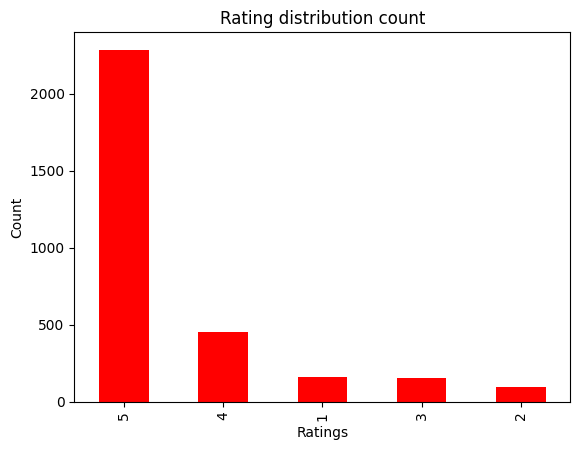

In [ ]:
## Bar plot visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

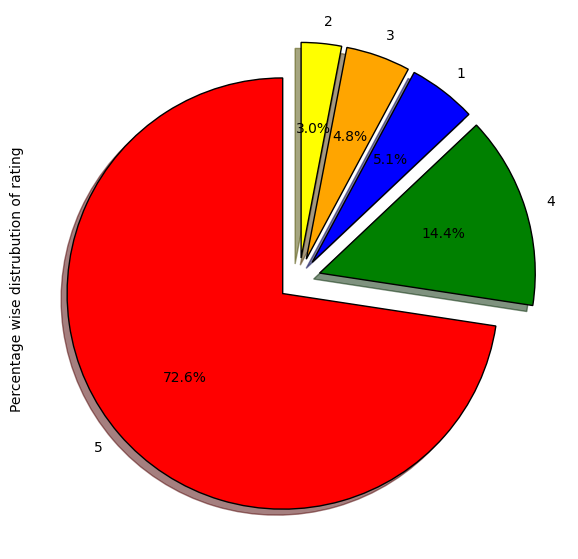

In [ ]:
##  pie chart visualization

fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

### Analyzing the "feedback" column

In [ ]:
## Distinct values of 'feedback' and its count

print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.

In [ ]:
## Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [ ]:
## Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


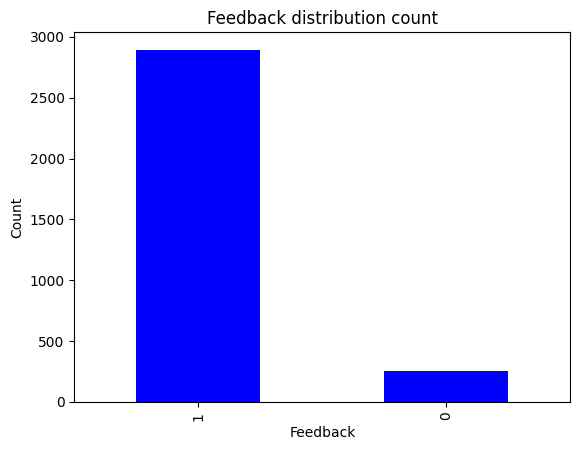

In [ ]:
## Bar graph to visualize the total counts of each feedback

data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [ ]:
## Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records

print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


**Conclusion** :- 91.87 % reviews are positive &
8.13 % reviews are negative

<Axes: ylabel='Percentage wise distrubution of feedback'>

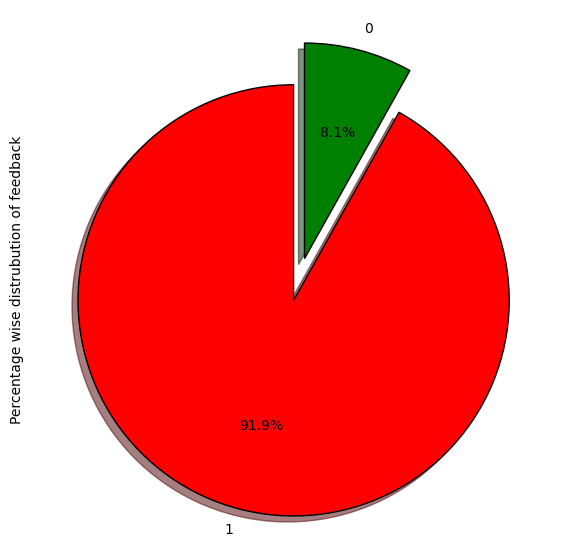

In [ ]:
## pie chart visualization

fig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

##### Let's see the 'rating' values for different values of 'feedback'

In [ ]:
## Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [ ]:
## Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

conclusion :- If rating of a review is 1 or 2 then the feedback is 0 (negative) and if the rating is 3, 4 or 5 then the feedback is 1 (positive).

## Analyzing 'variation' column

This column refers to the variation or type of Amazon Alexa product. Example - Black Dot, Charcoal Fabric etc.

In [ ]:
## Distinct values of 'variation' and its count

print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


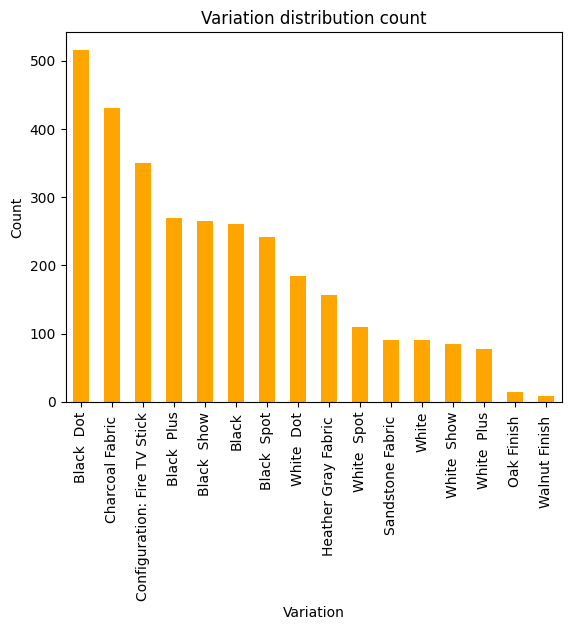

In [ ]:
## Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

## Analyzing 'verified_reviews' column

This column contains the textual review given by the user for a variation for the product.

In [ ]:
data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of length of review ')]

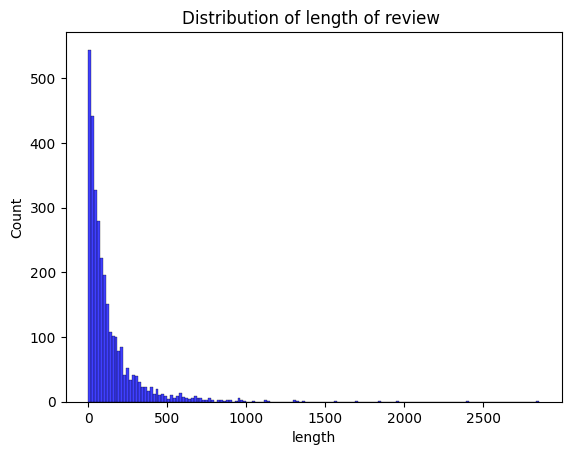

In [ ]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

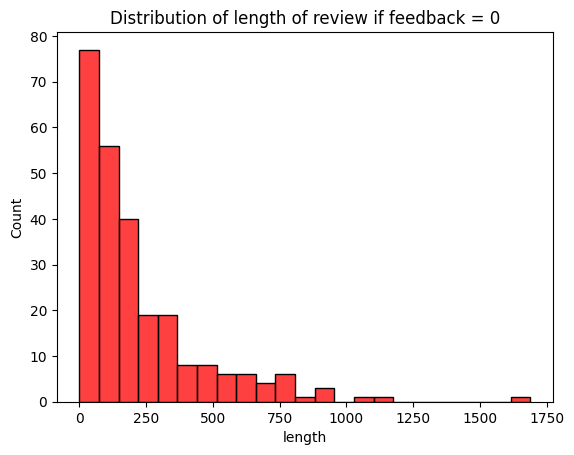

In [ ]:
## Length analysis when feedback is 0 (negative)
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

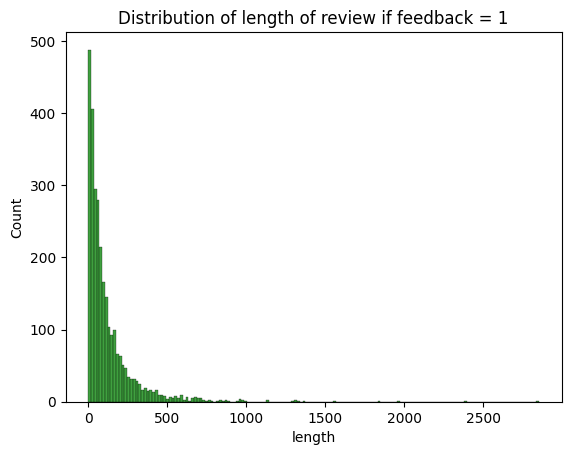

In [ ]:
## Length analysis when feedback is 1 (positive)
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

## Create WordCloud

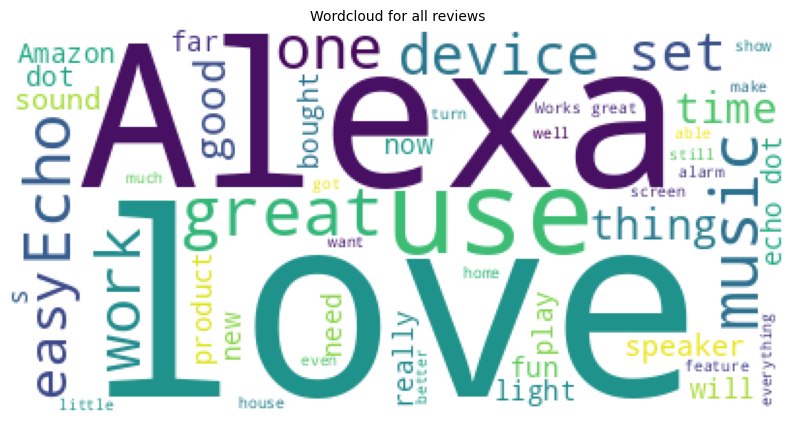

In [ ]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [ ]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

#### Negative word cloud

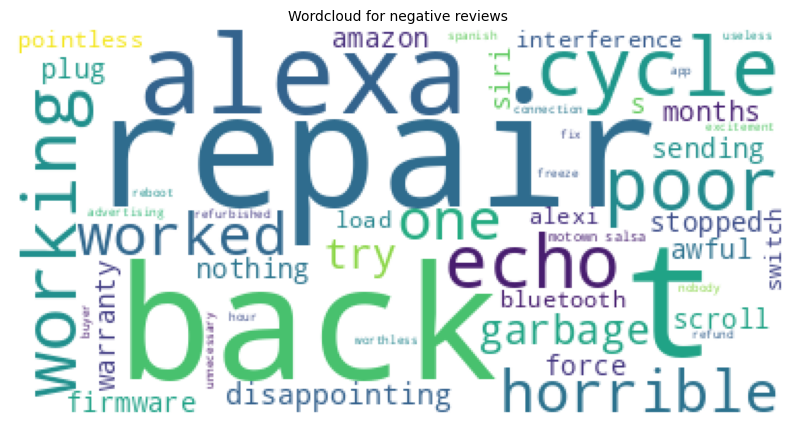

In [ ]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()


Positive word cloud

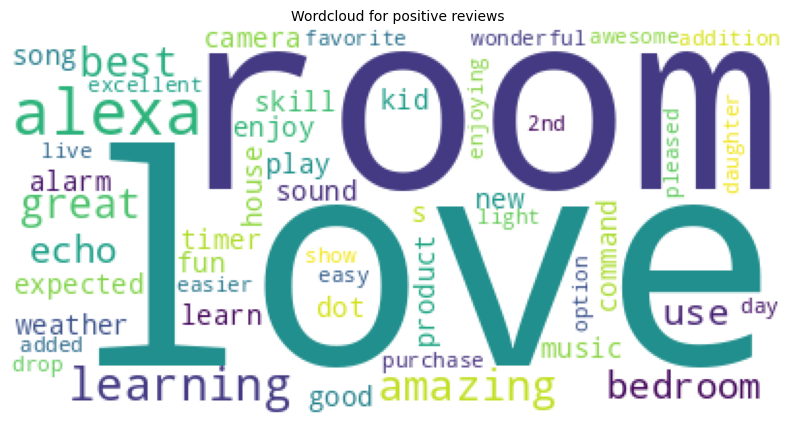

In [ ]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

# Preprocessing & Model Building

To build the corpus from the 'verified_reviews' we perform the following -

1. Replace any non alphabet characters with a space
2. Convert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

## Upsampling

This technique is used to handle the imbalanced data. When we are using an imbalanced dataset, we can oversample the minority class using replacement.

In [ ]:
from sklearn.utils import resample


# Separate majority and minority classes
df_majority = data[data.feedback == 1]
df_minority = data[data.feedback == 0]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # Sample with replacement
                                 n_samples=len(df_majority),    # To match majority class
                                 random_state=123) # Reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
print(df_upsampled['feedback'].value_counts())

feedback
1    2893
0    2893
Name: count, dtype: int64


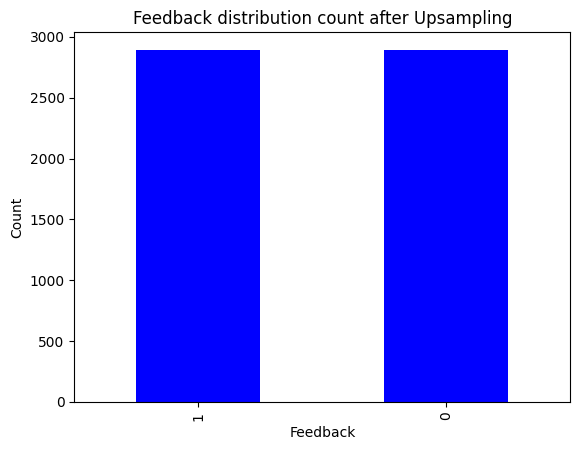

In [ ]:
## Bar graph to visualize the total counts of each feedback after Upsampling

df_upsampled['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count after Upsampling')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [ ]:
corpus = []  ## Initialize an empty list to store the processed reviews

stemmer = PorterStemmer()

for i in range(0,df_upsampled.shape[0]):

  ## Remove non-alphabetic characters
  review = re.sub('[^a-zA-Z]', ' ', df_upsampled.iloc[i]['verified_reviews'])

  ## Convert to lowercase and split into words
  review = review.lower().split()

  ## Stem the words and remove stopwords
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]

  ## Join the words back into a single string
  review = ' '.join(review)

  ## Add the processed review to the corpus
  corpus.append(review)

### Use TF-IDF Vectorizer to create bag of words

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf =TfidfVectorizer(max_features = 2500)

## Storing independent and dependent variables in X and y

## Transform the corpus into TF-IDF features & Stored in X variable
X = tfidf.fit_transform(corpus).toarray()

## Store the dependent variable in Y
Y = df_upsampled['feedback'].values

In [ ]:
## Saving the TF-IDF Vectorizer
pickle.dump(tfidf, open('tfidfVectorizer.pkl', 'wb'))

In [ ]:
## Checking the shape of X and Y
print(f"X shape: {X.shape}")
print(f"y shape: {Y.shape}")

X shape: (5786, 2500)
y shape: (5786,)


### Splitting data into train and test set with 20% data with testing.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (4628, 2500)
y train: (4628,)
X test: (1158, 2500)
y test: (1158,)


### Use MinMax Scaler to scale the data

In [ ]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [ ]:
## Saving the scaler model
pickle.dump(scaler, open('scaler.pkl', 'wb'))

### Model Selection

#### Random Forest

In [ ]:
## Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

## Accuracy of the model on training and testing data
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9870354364736387
Testing Accuracy : 0.9784110535405872


In [ ]:
## K-fold cross-validation

accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9749366544182958
Standard Variance : 0.004845923987594949


#### XGBOOST

In [ ]:
## Fitting scaled X_train and y_train on XGBOOST

model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

## Accuracy of the model on training and testing data

print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9732065687121867
Testing Accuracy : 0.9421416234887737


In [ ]:
## K-fold cross-validation

accuracies = cross_val_score(estimator = model_xgb, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9297902254516497
Standard Variance : 0.009321697901372708


#### Decision Tree Classifier

In [ ]:
## Fitting scaled X_train and y_train on DecisionTree

model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

#Accuracy of the model on training and testing data

print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9870354364736387
Testing Accuracy : 0.9568221070811744


In [ ]:
## K-fold cross-validation

accuracies = cross_val_score(estimator = model_dt, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9515993006273785
Standard Variance : 0.007492331492540818


**Conclusion** :- Best Model is RandomForest. Because Training Accuracy and Testing Accuracy is aproximately similar

### Saving the RandomForest classifier

In [ ]:

pickle.dump(model_rf, open('rfmodel.pkl', 'wb'))